# Phase II: Data Cleaning & EDA

The goal of this analysis is to build a model that predicts which Reddit forum a given post comes from, based primarily on the text attributes of each post. To this end, I'll be using the title of each post as the predominant X variable, as this is where the majority of the post's text is located. I also know that my target will be the subreddit column. Beyond this, some investigation is required before going any further. At this stage, I'm looking to answer two questions:

- Should any additional features be included in the list of predictors?
- To what extent should the text data be cleaned or processed?

---

### Importing Packages & Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline

### Reading in the Data:

In [2]:
df = pd.read_csv('./Datasets/Final_Reddit_Dataset.csv')

---

### Preliminary Exploration:

Initial examination of our classes shows that they are well-balanced. Posts from the EverythingScience subreddit are represented in slightly greater quantity than those of the Science subreddit:

In [3]:
df['subreddit'].value_counts(normalize=True)

EverythingScience    0.542276
science              0.457724
Name: subreddit, dtype: float64

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


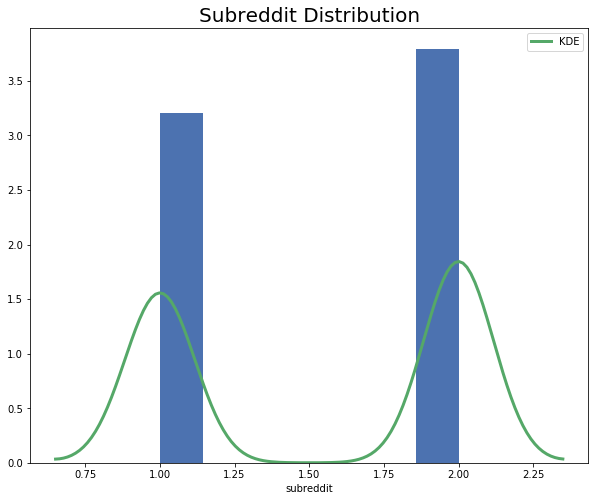

In [21]:
sns.set_color_codes("deep")
plt.figure(figsize=(10, 8))
sns.distplot(df['subreddit'].replace({'science': 1, 'EverythingScience': 2}), kde_kws={"color": "g", "lw": 3, "label": "KDE"},
                              hist_kws={"alpha": 1, "color": "b"})
plt.title("Subreddit Distribution", fontsize=20);

We get a lot of data points for each post, the majority of which is either HTML tags concerning post layout, webpage metrics, and user/author details. Many of these columns are null, and many of the non-null columns are not useful for our particular line of inquiry:

In [4]:
df.columns

Index(['approved_at_utc', 'approved_by', 'archived', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       ...
       'thumbnail_height', 'thumbnail_width', 'title', 'ups', 'url',
       'user_reports', 'view_count', 'visited', 'whitelist_status', 'wls'],
      dtype='object', length=102)

In [5]:
df.head()

,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,NaN,NaN,False,neutronfish,NaN,NaN,NaN,[],NaN,NaN,...,78.0,140.0,"Scientists and bureaucrats are really, really ...",274,https://worldofweirdthings.com/2018/10/03/the-...,[],NaN,False,all_ads,6
1,NaN,NaN,False,mvea,NaN,NaN,med reward3,[],NaN,MD-PhD-MBA | Clinical Professor/Medicine,...,140.0,140.0,School Boots Professor Off Campus After He Exp...,1217,https://www.techdirt.com/articles/20181209/145...,[],NaN,False,all_ads,6
2,NaN,NaN,False,KnowableMag,NaN,NaN,NaN,[],NaN,NaN,...,74.0,140.0,A gut-brain link for Parkinson’s gets a closer...,74,https://www.sciencenews.org/article/parkinsons...,[],NaN,False,all_ads,6
3,NaN,NaN,False,BlankVerse,NaN,NaN,NaN,[],NaN,NaN,...,73.0,140.0,The untold story of how India's sex workers pr...,41,https://www.theguardian.com/global-development...,[],NaN,False,all_ads,6
4,NaN,NaN,False,clayt6,NaN,NaN,NaN,[],NaN,NaN,...,93.0,140.0,Satellite images of penguin poop-stains in Ant...,129,http://www.astronomy.com/news/2018/12/penguin-...,[],NaN,False,all_ads,6


---

### Dealing with the Nulls:

Since the majority of the columns with null values were completely null, and the columns containing relatively few nulls were not informative or helpful to our inquiry, I decided to drop these columns completely. Of the columns that remained, I hand-picked the ones that I thought could potentially be useful for modeling. 

In [6]:
df.isnull().sum()[df.isnull().sum() > 0]

approved_at_utc                  1916
approved_by                      1916
author_cakeday                   1915
author_flair_background_color    1916
author_flair_css_class           1466
author_flair_richtext               3
author_flair_template_id         1916
author_flair_text                1620
author_flair_text_color          1463
author_flair_type                   3
author_fullname                     3
author_patreon_flair                3
banned_at_utc                    1916
banned_by                        1916
category                         1916
content_categories               1916
crosspost_parent                 1916
crosspost_parent_list            1916
distinguished                    1916
event_end                        1915
event_is_live                    1915
event_start                      1915
likes                            1916
link_flair_background_color      1057
link_flair_css_class              209
link_flair_template_id            223
link_flair_t

In [7]:
df.columns[df.isnull().sum() == 0]

Index(['archived', 'author', 'can_gild', 'can_mod_post', 'clicked',
       'contest_mode', 'created', 'created_utc', 'domain', 'downs', 'edited',
       'gilded', 'gildings', 'hidden', 'hide_score', 'id', 'is_crosspostable',
       'is_meta', 'is_original_content', 'is_reddit_media_domain',
       'is_robot_indexable', 'is_self', 'is_video', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_embed',
       'media_only', 'mod_reports', 'name', 'no_follow', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned', 'pwls', 'quarantine', 'saved', 'score', 'secure_media_embed',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_name_prefixed', 'subreddit_subscribers', 'subreddit_type',
       'thumbnail', 'title', 'ups', 'url', 'user_reports', 'visited',
       'whitelist_status', 'wls'],
      dtype='object')

In [14]:
df = df[['author', 'domain', 'num_comments', 'title', 'subreddit', 'url']]
      
df.head()

,author,domain,num_comments,title,subreddit,url
0,neutronfish,worldofweirdthings.com,7,"Scientists and bureaucrats are really, really ...",EverythingScience,https://worldofweirdthings.com/2018/10/03/the-...
1,mvea,techdirt.com,43,School Boots Professor Off Campus After He Exp...,EverythingScience,https://www.techdirt.com/articles/20181209/145...
2,KnowableMag,sciencenews.org,4,A gut-brain link for Parkinson’s gets a closer...,EverythingScience,https://www.sciencenews.org/article/parkinsons...
3,BlankVerse,theguardian.com,0,The untold story of how India's sex workers pr...,EverythingScience,https://www.theguardian.com/global-development...
4,clayt6,astronomy.com,2,Satellite images of penguin poop-stains in Ant...,EverythingScience,http://www.astronomy.com/news/2018/12/penguin-...


---

### Column Transformations

First things first - since the 'subreddit' column will be the target, it should be transformed into binary values. I called this **'subreddit_class'**. From here, I created the **'word_count'** and **'num_stopwords'** column to get a sense of the makeup of words in each document. I decided against removing stopwords, punctuation, and uppercase characters, and against tokenizing and lemmatizing, at least for now. Since these operations are all tunable parameters within the TF-IDF and Count Vectorizers, I will address them during the modeling phase which will allow for some experimentation with these parameters.

In [9]:
df['subreddit_class'] = df['subreddit'].map({'EverythingScience': 0, 'science': 1})

In [10]:
df.head(3)

,author,domain,num_comments,title,subreddit,url,subreddit_class
0,neutronfish,worldofweirdthings.com,7,"Scientists and bureaucrats are really, really ...",EverythingScience,https://worldofweirdthings.com/2018/10/03/the-...,0
1,mvea,techdirt.com,43,School Boots Professor Off Campus After He Exp...,EverythingScience,https://www.techdirt.com/articles/20181209/145...,0
2,KnowableMag,sciencenews.org,4,A gut-brain link for Parkinson’s gets a closer...,EverythingScience,https://www.sciencenews.org/article/parkinsons...,0


In [11]:
df['word_count'] = df['title'].apply(lambda x: len(str(x).split(" ")))
df['word_count'][:3]

0    26
1    14
2    20
Name: word_count, dtype: int64

In [12]:
stopwords = stopwords.words('english')
df['num_stopwords'] = df['title'].apply((lambda x: len([x for x in x.split() if x in stopwords])))
df.head(3).T

,0,1,2
author,neutronfish,mvea,KnowableMag
domain,worldofweirdthings.com,techdirt.com,sciencenews.org
num_comments,7,43,4
title,"Scientists and bureaucrats are really, really ...",School Boots Professor Off Campus After He Exp...,A gut-brain link for Parkinson’s gets a closer...
subreddit,EverythingScience,EverythingScience,EverythingScience
url,https://worldofweirdthings.com/2018/10/03/the-...,https://www.techdirt.com/articles/20181209/145...,https://www.sciencenews.org/article/parkinsons...
subreddit_class,0,0,0
word_count,26,14,20
num_stopwords,7,0,5


In [ ]:
#df.to_csv('./Datasets/Final_Reddit_Dataset_CLEAN.csv', index=False)